## [월별로평균기온을 분석하여 예측 해보자 feat.ARIMA]


In [213]:
import matplotlib.pyplot as plt      #시각화를 위한 설치
import matplotlib.font_manager as fm    # 한글 폰트
import matplotlib                   #시각화를 위한 설치
import os, warnings  
import pandas as pd                #구조 변경 및 결합을 하기 위한 설치
import seaborn as sns              #시각화를 위한 설치
import plotly.express as px        #시각화를 위한 설치

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)         #모든 행을 다 보여주라는 명령
pd.set_option('display.max_columns', None)      #모든 열을 다 보여주라는 명령

In [214]:
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False
## 한글 폰트 적용 ( 안하면 한글 깨짐 )
f_name = fm.FontProperties(fname="C:/Windows/Fonts/malgunbd.ttf").get_name()
plt.rc('font', family=f_name)

#### 날씨 데이터 불러오기(엑셀 파일에는1968년부터2019년의 데이터가 존재합니다.)

In [215]:
air= pd.read_csv('air.csv',encoding='ANSI')
air_2020= pd.read_csv('air_2020.csv',encoding='ANSI') #예측을 확인해볼 미래 데이터

In [216]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      624 non-null    object 
 1   평균기온    624 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.9+ KB


#### 년도 짜르기

In [217]:
air=air[(air['일시']>='2010-01-01')&(air['일시']<='2019-12-31')] 

In [218]:
air['일시']=air['일시'].astype('str')
air['일시']=pd.to_datetime(air['일시'])
air.index=air['일시']
air.set_index('일시',inplace=True)

Text(0, 0.5, '평균기온')

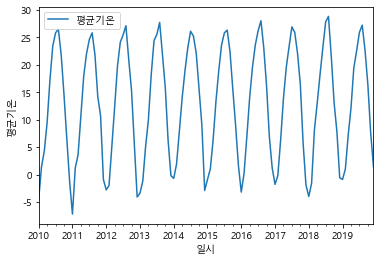

In [219]:
air.plot()
plt.xlabel('일시')
plt.ylabel('평균기온')

* 위 그래프 해석: 아래 일시별로 일정한 패턴이 존재함을 알 수 있습니다. 이는 비정상 시계열의 특징을 가지고 있는 불량한 데이터

## ARIMA에 대한 간단한 설명
- ARIMA(AutoRegressive Integrated Moving Average)는 자기 회귀 모델(AR)과 이동 평균 모델(MA)과 데이터의 정상성을 확보하기 위한 차분(I)을 합친 모델
- ARIMA모델은 AR , I, MA의 차수를 정해야 하는데 이는 ARIMA(p, d, q)로 나타낸다.
- AR의 차수는 p, I의 차수는 d, MA의 차수는 q로 표시한다. ARIMA(1,1,0) 일 경우 AR(1)와 I(1)를 합친 모델이라는 의미이다.

### [Step1] d(차분) 구하기
- 시계열 분석을 하기 위해서는 기본적으로 시계열이 정상성(stationary)이 있다는 가정을 만족해야 한다. 일반적으로 ADF(Augmented Dickey Fuller) Test 결과 p value 가 0.05 보다 작으면 정상성이 있다고 본다.

In [220]:
# AD-Fuller Test : 시계열의 정상성(stationary) 한지 확인

from statsmodels.tsa.stattools import adfuller

""" 차분 방법 """
air_diff =air - air.shift(1)
print(air)

y = air.dropna()
y1diff = air_diff.dropna()
result = adfuller(y)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')
result = adfuller(y1diff)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.3f}')

            평균기온
일시              
2010-01-01  -4.5
2010-02-01   1.4
2010-03-01   4.3
2010-04-01   9.5
2010-05-01  17.2
2010-06-01  23.4
2010-07-01  25.8
2010-08-01  26.5
2010-09-01  21.8
2010-10-01  14.5
2010-11-01   6.5
2010-12-01  -1.3
2011-01-01  -7.2
2011-02-01   1.2
2011-03-01   3.6
2011-04-01  10.7
2011-05-01  17.9
2011-06-01  22.0
2011-07-01  24.6
2011-08-01  25.8
2011-09-01  21.8
2011-10-01  14.2
2011-11-01  10.7
2011-12-01  -0.9
2012-01-01  -2.8
2012-02-01  -2.0
2012-03-01   5.1
2012-04-01  12.3
2012-05-01  19.7
2012-06-01  24.1
2012-07-01  25.4
2012-08-01  27.1
2012-09-01  21.0
2012-10-01  15.3
2012-11-01   5.5
2012-12-01  -4.1
2013-01-01  -3.4
2013-02-01  -1.2
2013-03-01   5.1
2013-04-01  10.0
2013-05-01  18.2
2013-06-01  24.4
2013-07-01  25.5
2013-08-01  27.7
2013-09-01  21.8
2013-10-01  15.8
2013-11-01   6.2
2013-12-01  -0.2
2014-01-01  -0.7
2014-02-01   1.9
2014-03-01   7.9
2014-04-01  14.0
2014-05-01  18.9
2014-06-01  23.1
2014-07-01  26.1
2014-08-01  25.2
2014-09-01  22

 * 1차 차분을 한 것의 p-value가 0.05이하이므로 정상성을 보인다.
 - 이로서 차분(d)의 차수는 1인 ARIMA(p, 1, q)의 모델 구축이 필요하다는 것을 알 수 있다.

### [Step2] p,q를 구하는 2가지 방식 
1. acf함수와 pacf함수 활용
2. 파라미터를 각각 대입하여 AIC가 가장 작은 값을 도출한다.

1.acf함수와 pacf함수 활용

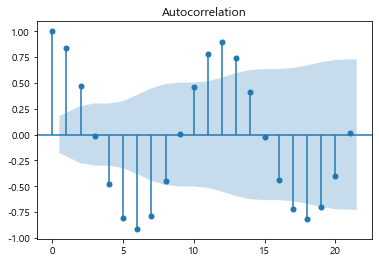

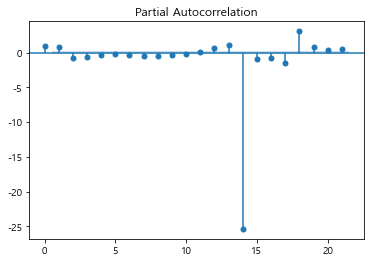

In [221]:
plot_acf(air)
plot_pacf(air)
plt.show()

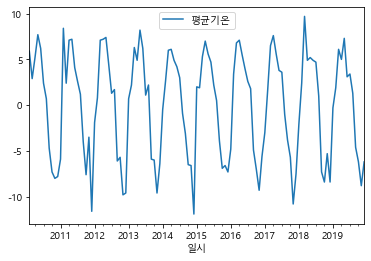

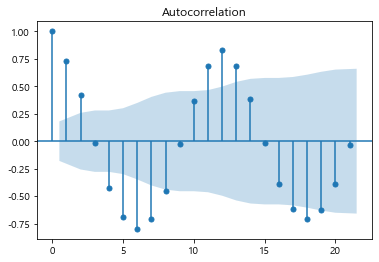

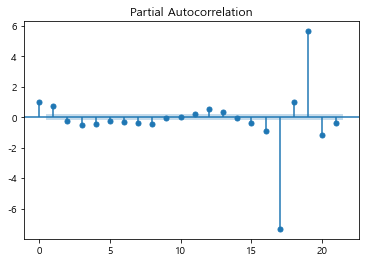

In [222]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
diff_1=air.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

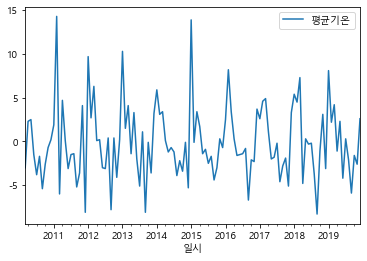

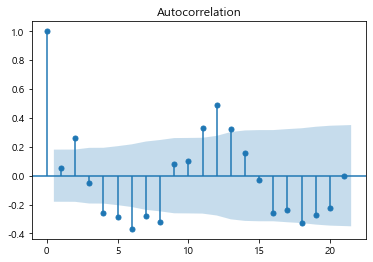

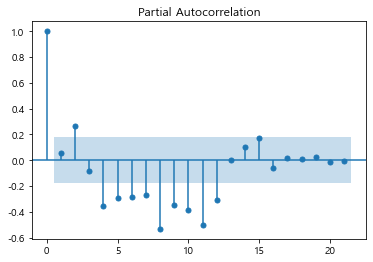

In [223]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
diff_2=diff_1.diff(periods=1).iloc[1:]
diff_2.plot()
plot_acf(diff_2)
plot_pacf(diff_2)
plt.show()

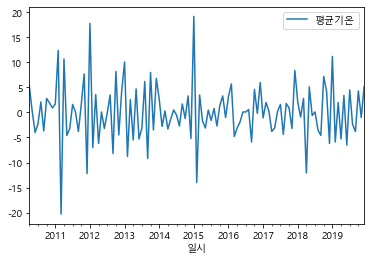

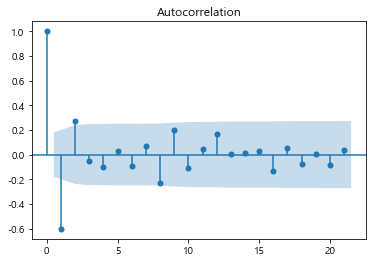

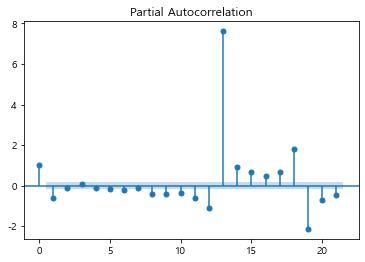

In [224]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
diff_3=diff_2.diff(periods=1).iloc[1:]
diff_3.plot()
plot_acf(diff_3)
plot_pacf(diff_3)
plt.show()

- 위 그림으로는 p,q가 파악이 안된다고 생각하여  파라미터를 각각 대입하여 AIC가 가장 작은 값을 도출한다.

In [225]:
import itertools
p=d=q=range(0,5)
pdq=list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [226]:
import warnings
warnings.filterwarnings('ignore')

for param in pdq:
    try:
        model_arima=ARIMA(air.평균기온.values, order=param)
        model_arima_fit=model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 906.2060213282756
(0, 0, 1) 783.7574082906877
(0, 0, 3) 665.635771537538
(0, 0, 4) 642.4083948994344
(0, 1, 0) 755.2650584910562
(0, 1, 1) 697.4634567143526
(0, 1, 2) 668.2597489370679
(0, 1, 3) 645.0174319886598
(0, 1, 4) 644.8609687844682
(0, 2, 0) 674.5042042215975
(0, 2, 1) 676.2658853804172
(0, 2, 2) 663.544008781296
(0, 2, 3) 665.0808281870271
(0, 2, 4) 644.8762946326362
(1, 0, 0) 756.2836819298207
(1, 0, 1) 695.1196702580319
(1, 0, 2) 663.8608007783255
(1, 0, 3) 709.610173742654
(1, 0, 4) 662.6874694935677
(1, 1, 0) 666.147734475787
(1, 1, 2) 692.9208914822367
(1, 1, 3) 661.7196338607803
(1, 1, 4) 633.0205079185998
(1, 2, 0) 676.1419330658489
(1, 2, 2) 664.982779744603
(1, 2, 3) 646.5759078963044
(2, 0, 0) 595.2466729589155
(2, 0, 2) 497.13786052036966
(2, 0, 3) 486.5775518853704
(2, 1, 0) 662.296603780291
(2, 1, 3) 496.2402247471221
(2, 2, 0) 670.1016534443552
(2, 2, 2) 668.166237042213
(2, 2, 3) 528.2123431067839
(3, 0, 0) 552.506872337989
(3, 0, 4) 512.0402622691399

* d가 1인 값들중 aic가 가장 낮은 (2,1,3)으로 결정

### 아래 statsmoel패키지는 ARIMA모델을 작성할 때 사용되는 통계분석을 위한 패키지입니다.

In [14]:
pip install statsmodels 

Note: you may need to restart the kernel to use updated packages.


In [227]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

#(ar=2,차분=1, ma=3)파라미터로 arima모델을 학습
model=ARIMA(air['평균기온'], order=(2,1,3))
model_fit=model.fit(trend='nc',full_output=True,disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.평균기온   No. Observations:                  119
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -240.752
Method:                       css-mle   S.D. of innovations              1.726
Date:                Thu, 21 Oct 2021   AIC                            493.504
Time:                        15:30:57   BIC                            510.179
Sample:                    02-01-2010   HQIC                           500.276
                         - 12-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.평균기온     1.7316      0.001   2464.280      0.000       1.730       1.733
ar.L2.D.평균기온    -0.9999        nan        nan        nan         nan         nan
ma.L1.D.평균기온    -2.6553        nan        na

*  AIC (AKaike Information Criterion) : 데이터에 대한 모델의 상대적 품질
- 값이 낮을수록 모형 적합도가 높은것을 의미 합니다.

#### 잠깐: ARIMA 분석의 파라미터
* 위 예제의 분석 결과와는 별개로 order 파라미터 p, d, q는 일반적인 가이드라인이 존재한다. 보통은 p와 q의 합이 2 미만인 경우, 혹은 p와 q의 곱이 0을 포함한 짝수인 경우가 좋은 파라미터의 조합이라고 알려져 있다.

### 예측값과 실제값의 비교

<AxesSubplot:xlabel='일시'>

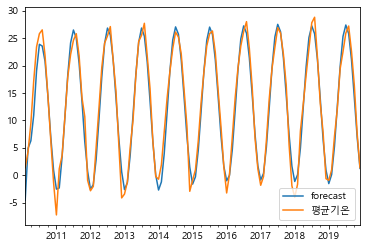

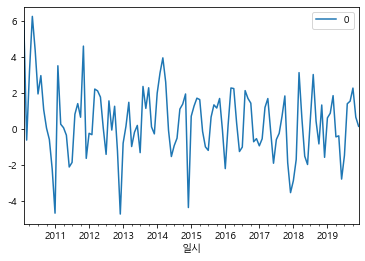

In [228]:
fig=model_fit.plot_predict()
residuals=pd.DataFrame(model_fit.resid)
residuals.plot()

#### 2020년도의 예측이 맞는지 확인

In [229]:
air_2020.index=air_2020['일시']
air_2020.set_index('일시',inplace=True)

In [230]:
air_2020_h=air_2020.head(12)

In [231]:
forecast_data=model_fit.forecast(steps=12) 

pred_y=forecast_data[0].tolist()
test_y=air_2020_h.평균기온.values 

# 2020년도를 예측한 값

In [232]:
pred_y 

[-1.2525053666780903,
 0.11456712974370409,
 5.018780452333756,
 12.14393712971162,
 19.578059238226928,
 25.32645213034324,
 27.84691310467775,
 26.46347992432668,
 21.547717026054137,
 14.41892031343523,
 6.9900436209758094,
 1.254373339545972]

# 2020년도의 실제값

In [181]:
test_y #실제값

array([ 1.6,  2.5,  7.7, 11.1, 18. , 23.9, 24.1, 26.5, 21.4, 14.3,  8. ,
       -0.3])

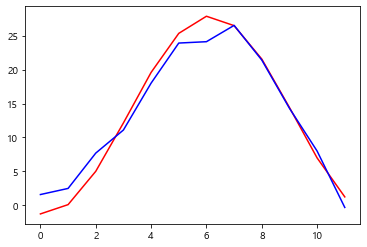

In [182]:
plt.plot(pred_y,color='red') #에측값
plt.plot(test_y,color='blue') #실제값

* 위에서 가장 낮은 숫자를 찾아 대입

#### 예측성능 평가

In [207]:
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

rmse=sqrt(mean_squared_error(pred_y,test_y))
print(rmse)

36.334938142965676


 # -------------------------------------------------------------------------------------------------------------

## [Facebook Prophet활용하기]

In [24]:
from fbprophet import Prophet

* facebook prophet은 날짜를 ds로 해야하고 독립변수를 y라고 설정해야 합니다.

In [29]:
air.columns=['ds','y']
air_2020.columns=['ds','y']

In [30]:
air=air[(air['ds']>='2010-01-01')&(air['ds']<='2019-12-31')] 

In [58]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
prophet.fit(air)

In [78]:
future_data = prophet.make_future_dataframe(periods = 12, freq = 'm')
forecast_data = prophet.predict(future_data)
a=forecast_data[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(12)

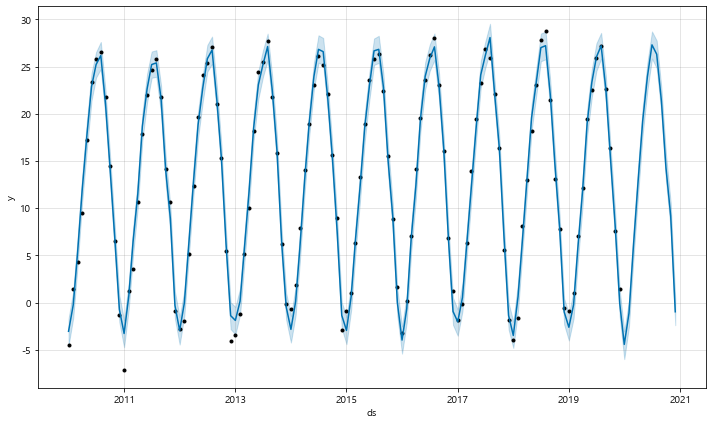

In [79]:
fig1=prophet.plot(forecast_data)

* 2019년도까지의 데이터를 가지고 2020년도의 월별 평균 기온을 예측

In [62]:
future_data_2 = prophet.make_future_dataframe(periods = 370, freq = 'd')
forecast_data_2 = prophet.predict(future_data_2)
a_2=forecast_data_2[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(370)

In [63]:
a_2['day']=a_2['ds'].dt.day

In [64]:
a_2=a_2[a_2['day']==1] 

In [65]:
a_2

,ds,yhat,yhat_lower,yhat_upper,day
150,2020-01-01,-3.565967,-5.021101,-2.243592,1
181,2020-02-01,-0.258352,-1.700971,1.223788,1
210,2020-03-01,6.575380,5.091541,7.998245,1
241,2020-04-01,12.623400,11.162936,14.094503,1
271,2020-05-01,18.293061,16.832225,19.662943,1
302,2020-06-01,23.044773,21.591415,24.473364,1
332,2020-07-01,25.873800,24.469569,27.281835,1
363,2020-08-01,27.070790,25.685822,28.472940,1
394,2020-09-01,22.757509,21.313038,24.170835,1
424,2020-10-01,16.484375,15.108592,17.853507,1


In [66]:
a_2.reset_index(drop=True)

,ds,yhat,yhat_lower,yhat_upper,day
0,2020-01-01,-3.565967,-5.021101,-2.243592,1
1,2020-02-01,-0.258352,-1.700971,1.223788,1
2,2020-03-01,6.575380,5.091541,7.998245,1
3,2020-04-01,12.623400,11.162936,14.094503,1
4,2020-05-01,18.293061,16.832225,19.662943,1
5,2020-06-01,23.044773,21.591415,24.473364,1
6,2020-07-01,25.873800,24.469569,27.281835,1
7,2020-08-01,27.070790,25.685822,28.472940,1
8,2020-09-01,22.757509,21.313038,24.170835,1
9,2020-10-01,16.484375,15.108592,17.853507,1


In [67]:
pred_y=a_2.yhat.values[0:11]
test_y=air_2020.y.values[0:11]

In [68]:
pred_y #2020년도의 에측값

array([-3.56596711, -0.25835213,  6.57538008, 12.62339972, 18.29306125,
       23.04477304, 25.87379974, 27.07078955, 22.75750933, 16.48437507,
        6.48749061])

In [69]:
test_y #2020년도의 실제값

array([ 1.6,  2.5,  7.7, 11.1, 18. , 23.9, 24.1, 26.5, 21.4, 14.3,  8. ])

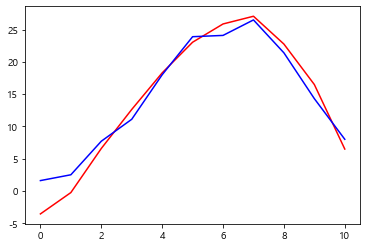

In [70]:
plt.plot(pred_y,color='red') #에측값
plt.plot(test_y,color='blue') #실제값

In [1]:
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
rmse=sqrt(mean_squared_error(pred_y,test_y))
print(rmse)

NameError: name 'pred_y' is not defined

* 2019년도와 2020년도의 오차값을 나타낸 것.

### 결론
- ARIMA모델의 RMSE값이 더 낮게 나와 ARIMA모델의 예측 정확성이 더 높은 것으로 판단됩니다.